# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [2]:
# Load the data
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [4]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [5]:
from torch.utils.data import WeightedRandomSampler

In [6]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [7]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [8]:
from torch.utils.data import DataLoader

In [9]:
# create standard dataloaders using all of the MNIST data

batch_size = 16

#train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
#test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [10]:
from tqdm import tqdm

In [11]:
loader_size = 1024

stacked_data_loaders = []
for label in tqdm(range(10)):
    #print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.4), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:09<00:00,  7.08s/it]


In [12]:
import federated

learning_rate = 5e-1
num_epochs = 1
num_rounds = 3

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [13]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/3 [00:00<?, ?it/s]

Training 3 round(s) with 10 worker(s) doing 1 epoch(s) each
Beginning round 0
    Worker: 9736 Epoch:  0
        Worker: 9736 Batch: 000 Loss: 2.3148
    Worker: 9544 Epoch:  0
        Worker: 9544 Batch: 000 Loss: 2.3131
    Worker: 384 Epoch:  0
        Worker: 384 Batch: 000 Loss: 2.3000
    Worker: 832 Epoch:  0
        Worker: 832 Batch: 000 Loss: 2.2867
    Worker: 1280 Epoch:  0
        Worker: 1280 Batch: 000 Loss: 2.3062
    Worker: 1728 Epoch:  0
        Worker: 1728 Batch: 000 Loss: 2.3073
    Worker: 2176 Epoch:  0
        Worker: 2176 Batch: 000 Loss: 2.2992
    Worker: 2624 Epoch:  0
        Worker: 2624 Batch: 000 Loss: 2.3002
    Worker: 3072 Epoch:  0
        Worker: 3072 Batch: 000 Loss: 2.3059
    Worker: 3184 Epoch:  0
        Worker: 3184 Batch: 000 Loss: 2.2932


 33%|███▎      | 1/3 [00:20<00:40, 20.36s/it]

    Round: 000 Loss: 2.30343
Beginning round 1
    Worker: 9736 Epoch:  0
        Worker: 9736 Batch: 000 Loss: 2.3028
    Worker: 9544 Epoch:  0
        Worker: 9544 Batch: 000 Loss: 2.3168
    Worker: 384 Epoch:  0
        Worker: 384 Batch: 000 Loss: 2.3223
    Worker: 832 Epoch:  0
        Worker: 832 Batch: 000 Loss: 2.2917
    Worker: 1280 Epoch:  0
        Worker: 1280 Batch: 000 Loss: 2.3011
    Worker: 1728 Epoch:  0
        Worker: 1728 Batch: 000 Loss: 2.2889
    Worker: 2176 Epoch:  0
        Worker: 2176 Batch: 000 Loss: 2.3218
    Worker: 2624 Epoch:  0
        Worker: 2624 Batch: 000 Loss: 2.2874
    Worker: 3072 Epoch:  0
        Worker: 3072 Batch: 000 Loss: 2.3183
    Worker: 3184 Epoch:  0
        Worker: 3184 Batch: 000 Loss: 2.3062


 67%|██████▋   | 2/3 [00:41<00:20, 20.60s/it]

    Round: 001 Loss: 2.29839
Beginning round 2
    Worker: 9736 Epoch:  0
        Worker: 9736 Batch: 000 Loss: 2.3406
    Worker: 9544 Epoch:  0
        Worker: 9544 Batch: 000 Loss: 2.2280
    Worker: 384 Epoch:  0
        Worker: 384 Batch: 000 Loss: 2.2819
    Worker: 832 Epoch:  0
        Worker: 832 Batch: 000 Loss: 2.3001
    Worker: 1280 Epoch:  0
        Worker: 1280 Batch: 000 Loss: 2.3107
    Worker: 1728 Epoch:  0
        Worker: 1728 Batch: 000 Loss: 2.3013
    Worker: 2176 Epoch:  0
        Worker: 2176 Batch: 000 Loss: 2.3164
    Worker: 2624 Epoch:  0
        Worker: 2624 Batch: 000 Loss: 2.2444
    Worker: 3072 Epoch:  0
        Worker: 3072 Batch: 000 Loss: 2.2483
    Worker: 3184 Epoch:  0
        Worker: 3184 Batch: 000 Loss: 2.3222


100%|██████████| 3/3 [01:02<00:00, 20.62s/it]

    Round: 002 Loss: 2.30593


10


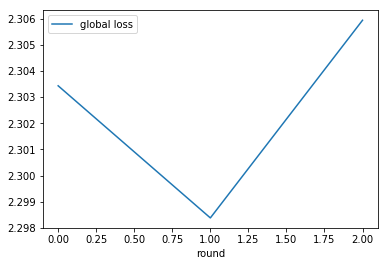

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");
ax.legend();

print(len(manager.worker_loss_histories))

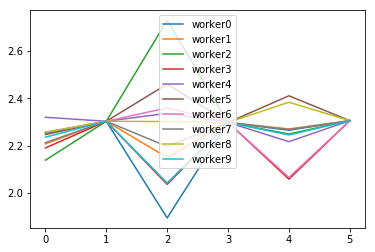

In [15]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();